In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob

from scipy import stats

import ajf_plts

SEED = ajf_plts.get_seed('temp_to_freq_model.ipynb')

plt.style.use(['./ajf_plts/base.mplstyle',
               './ajf_plts/legend_frame.mplstyle'])

This code does the follow steps:
* Joins together the various MIDAS year files
* Converts the index to be half hourly to match the SSI freqs
* Interpolates the NaNs that are placed at the half hour positions

# Load MIDAS weather data

In [381]:
midas_df = (
    pd.concat(
        [
            pd.read_csv(
                f,
                engine="python",
                skiprows=280,
                skipfooter=1,
                usecols=["ob_time", "air_temperature"],
                parse_dates=["ob_time"],
                infer_datetime_format=True,
                index_col=["ob_time"],
            ).dropna()
            for f in glob.glob("midas-*.csv")
        ]
    )
    .asfreq("1H")
)

print(midas_df)
midas_df.describe()

                     air_temperature
ob_time                             
2018-01-01 00:00:00              3.9
2018-01-01 01:00:00              3.8
2018-01-01 02:00:00              4.1
2018-01-01 03:00:00              4.0
2018-01-01 04:00:00              4.3
...                              ...
2020-12-31 19:00:00              4.9
2020-12-31 20:00:00              4.7
2020-12-31 21:00:00              4.7
2020-12-31 22:00:00              4.4
2020-12-31 23:00:00              3.8

[26304 rows x 1 columns]


,air_temperature
count,26286.000000
mean,9.429084
std,4.928099
min,-4.100000
25%,5.800000
50%,9.100000
75%,12.900000
max,28.600000


## Fill in missing values

In [382]:
print(midas_df[midas_df.isna().values])

                     air_temperature
ob_time                             
2018-01-05 13:00:00              NaN
2018-01-05 14:00:00              NaN
2018-01-05 15:00:00              NaN
2018-07-18 11:00:00              NaN
2018-07-18 12:00:00              NaN
2018-07-25 16:00:00              NaN
2018-07-25 17:00:00              NaN
2018-07-25 18:00:00              NaN
2018-07-25 19:00:00              NaN
2019-01-28 13:00:00              NaN
2019-01-28 14:00:00              NaN
2019-07-24 12:00:00              NaN
2019-07-24 13:00:00              NaN
2019-08-02 16:00:00              NaN
2019-11-12 14:00:00              NaN
2019-11-12 15:00:00              NaN
2020-01-16 11:00:00              NaN
2020-01-16 12:00:00              NaN


In [383]:
midas_df = midas_df.interpolate().reset_index().rename(columns={'ob_time':'time'})
print(midas_df)

                     time  air_temperature
0     2018-01-01 00:00:00              3.9
1     2018-01-01 01:00:00              3.8
2     2018-01-01 02:00:00              4.1
3     2018-01-01 03:00:00              4.0
4     2018-01-01 04:00:00              4.3
...                   ...              ...
26299 2020-12-31 19:00:00              4.9
26300 2020-12-31 20:00:00              4.7
26301 2020-12-31 21:00:00              4.7
26302 2020-12-31 22:00:00              4.4
26303 2020-12-31 23:00:00              3.8

[26304 rows x 2 columns]


# Load in bridge frequency data

In [384]:
import scipy.io

mode_1_mat = scipy.io.loadmat("mode_1.mat")

time1 = pd.to_datetime(mode_1_mat["Time"].reshape(-1), unit="s")
freq1 = mode_1_mat["Frequency"].reshape(-1)
temp1 = mode_1_mat["TempT_0"].reshape(-1)

gh_df = pd.DataFrame({"time": time1, "freq": freq1}).sort_values(
    "time"
)
print(gh_df)
gh_df.describe()

                     time      freq
0     2018-10-19 06:17:06  5.707690
1     2018-10-19 06:47:06  5.705696
2     2018-10-19 07:17:06  5.713192
3     2018-10-19 07:47:06  5.689763
4     2018-10-19 08:17:06  5.675845
...                   ...       ...
18426 2021-03-30 04:47:20  5.693058
18427 2021-03-30 05:17:20  5.702516
18428 2021-03-30 05:47:21  5.684138
18429 2021-03-30 06:17:21  5.658545
18430 2021-03-30 06:47:21  5.679977

[18431 rows x 2 columns]


,freq
count,18431.000000
mean,5.683987
std,0.130653
min,5.003418
25%,5.594548
50%,5.708642
75%,5.766512
max,6.492711


In [489]:
df = (
    pd.merge_asof(
        left=midas_df,
        right=gh_df,
        on='time',
        tolerance=pd.Timedelta("1H"),
        direction="nearest",
    )
    .set_index("time")
)

# remove nans at top and tail of dataset
df = df.loc[df.dropna().index.min() <= df.index]
df = df.loc[df.index <= df.dropna().index.max()]

full_df = df.copy()
print(df)

                     air_temperature      freq
time                                          
2018-10-19 06:00:00              8.2  5.707690
2018-10-19 07:00:00              8.4  5.705696
2018-10-19 08:00:00              8.6  5.689763
2018-10-19 09:00:00              8.8  5.680789
2018-10-19 10:00:00              9.7  5.705422
...                              ...       ...
2020-12-23 21:00:00              3.0  5.849363
2020-12-23 22:00:00              2.5  5.849589
2020-12-23 23:00:00              2.4  5.857112
2020-12-24 00:00:00              3.6  5.844593
2020-12-24 01:00:00              3.9  5.881038

[19124 rows x 2 columns]


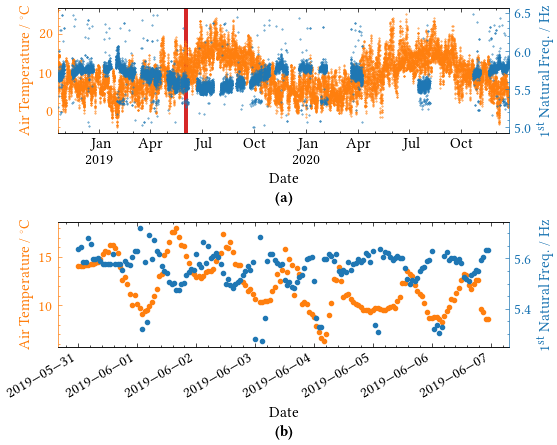

In [490]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, 2.0*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=2)

freq_vals = df.freq.dropna()

axes2 = [ax.twinx() for ax in axes]

df.air_temperature.plot(ax=axes[0], ls='', c='C1', marker='.', markersize=0.75, rasterized=True)
df.freq.plot(ax=axes2[0], ls='', c='C0', marker='.', markersize=0.75, rasterized=True)

start_date = '2019-5-31'
end_date = '2019-6-7'

mask = (df.index >= start_date) & (df.index <= end_date)
df[mask].dropna().air_temperature.plot(ax=axes[1], ls='', c='C1', marker='.')
df[mask].dropna().freq.plot(ax=axes2[1], ls='', c='C0', marker='.')

axes[0].axvspan(start_date, end_date, fc='C3')

for ax in axes:
    ax.set_xlabel('Date')
    
for ax in axes:
    ax.set_ylabel(r'Air Temperature / \unit{\celsius}', c='C1')
    ax.tick_params(axis='y', which='both', colors='C1')
    ax.spines['left'].set_color('C1')
    ax.spines['right'].set_visible(False)

for ax in axes2:
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}', c='C0')
    ax.tick_params(axis='y', which='both', colors='C0')
    ax.spines['right'].set_color('C0')
    ax.spines['left'].set_visible(False)
    
ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, 'figRawFirstFrequenciesTemps.pdf')

## Find outliers

In [491]:
def median_absolute_deviation(x):
    """
    Returns the median absolute deviation from the window's median
    :param x: Values in the window
    :return: MAD
    """
    return np.median(np.abs(x - np.median(x)))


def hampel(ts, window_size=5, n=3, imputation=False):

    """
    Median absolute deviation (MAD) outlier in Time Series
    :param ts: a pandas Series object representing the timeseries
    :param window_size: total window size will be computed as 2*window_size + 1
    :param n: threshold, default is 3 (Pearson's rule)
    :param imputation: If set to False, then the algorithm will be used for outlier detection.
        If set to True, then the algorithm will also imput the outliers with the rolling median.
    :return: Returns the outlier indices if imputation=False and the corrected timeseries if imputation=True
    """

    if type(ts) != pd.Series:
        raise ValueError("Timeserie object must be of tyme pandas.Series.")

#    if type(window_size) == int:
#        raise ValueError("Window size must be of type integer.")
#    else:
#        if window_size <= 0:
#            raise ValueError("Window size must be more than 0.")
#
#     if type(n) != int:
#         raise ValueError("Window size must be of type integer.")
#     else:
#         if n < 0:
#             raise ValueError("Window size must be equal or more than 0.")

    # Copy the Series object. This will be the cleaned timeserie
    ts_cleaned = ts.copy()

    # Constant scale factor, which depends on the distribution
    # In this case, we assume normal distribution
    rolling_ts = ts_cleaned.rolling(window_size, min_periods=1, center=True)
    rolling_median = rolling_ts.median().fillna(method='bfill').fillna(method='ffill')
    rolling_mad = (rolling_ts.apply(median_absolute_deviation).fillna(method='bfill').fillna(method='ffill'))

    outlier_indices = list(
        np.array(np.where(np.abs(ts_cleaned - rolling_median) >= (n * rolling_mad))).flatten())

    if imputation:
        ts_cleaned[outlier_indices] = rolling_median[outlier_indices]
        return ts_cleaned

    return outlier_indices

outliers = hampel(ts=df.freq, window_size=int(24), n=3.5)
df.freq.iloc[outliers] = np.nan

print(len(outliers))

735


## Check outliers are at night

Total outliers: N=735 (3.84%)
Day outliers:   N=74 (0.39%)
Night outliers: N=661 (3.46%)


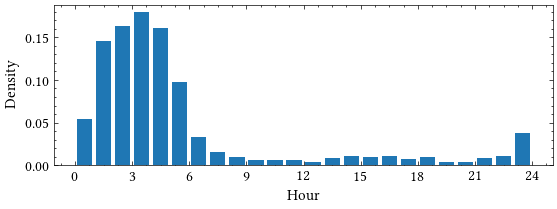

In [492]:
outlier_hours = df.index[outliers].hour

day_hours = np.arange(7, 19)

day_outliers = outlier_hours.isin(day_hours).sum()
night_outliers = (~(outlier_hours.isin(day_hours))).sum()

print(f'Total outliers: N={len(outliers)} ({len(outliers)/len(df):2.2%})')
print(f'Day outliers:   N={day_outliers} ({day_outliers/len(df):2.2%})')
print(f'Night outliers: N={night_outliers} ({night_outliers/len(df):2.2%})')

%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)
outlier_hours.to_series().plot(kind='hist', density=True, rwidth=0.8, bins=np.arange(25))
ax.set_xlabel('Hour')
ax.set_xticks(np.arange(25)[::3])
ax.set_ylabel('Density')
fig.tight_layout()
ajf_plts.save_fig(fig, 'figOutlierTimes.pdf')

## Interpolate gaps

In [493]:
interp_df = df.copy().dropna()

max_gap = pd.Timedelta('6H')
interp_df['time'] = interp_df.index
interp_df['block_id'] = ((interp_df.time - interp_df.time.shift()) > max_gap).cumsum()
interp_df = interp_df.drop(columns='time').asfreq('1H')
interp_df['block_id'] = interp_df.block_id.ffill()

groups = []
for i, group in interp_df.groupby(by='block_id'):
    groups.append(group.interpolate(method='cubic', limit=6, limit_area='inside'))
interp_df = pd.concat(groups)

## Plot

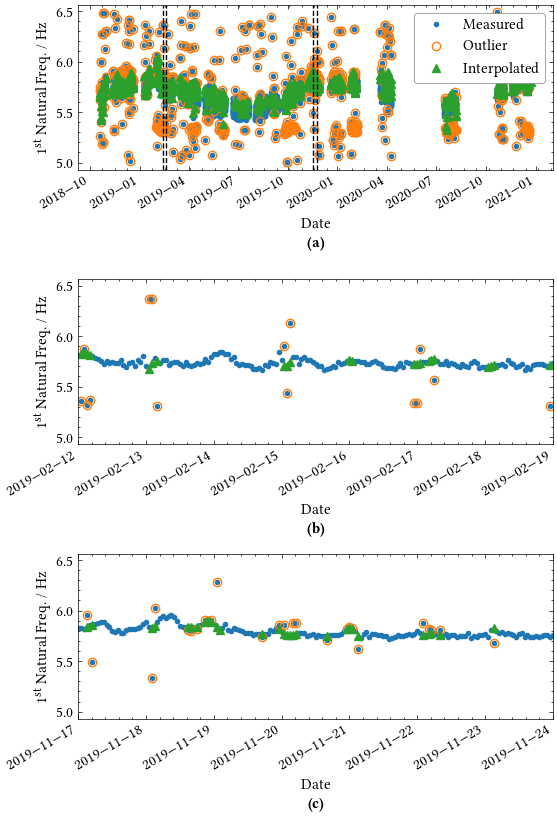

In [495]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.text_height_inches)
fig, axes = plt.subplots(figsize=figsize, nrows=3)
axes=axes.ravel()

for ax in axes:
    full_df.freq.dropna().plot(ax=ax, ls='', marker='.', label='Measured', rasterized=True)
    full_df.freq[outliers].plot(ax=ax, ls='', marker='o', markerfacecolor='none', label='Outlier', rasterized=True)
    interp_df.freq[interpolated].plot(ax=ax, ls='', marker='^', label='Interpolated', rasterized=True)
    ax.set_xlabel('Date')
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
    
axes[0].legend(loc='upper right')
    
axes[1].set_xlim((pd.Timestamp('2019-02-12'), pd.Timestamp('2019-02-19')))
axes[0].axvline(pd.Timestamp('2019-02-12'), c='k', ls='--')
axes[0].axvline(pd.Timestamp('2019-02-19'), c='k', ls='--')
    
axes[2].set_xlim((pd.Timestamp('2019-11-17'), pd.Timestamp('2019-11-24')))
axes[0].axvline(pd.Timestamp('2019-11-17'), c='k', ls='--')
axes[0].axvline(pd.Timestamp('2019-11-24'), c='k', ls='--')

ajf_plts.caption_axes(axes)
fig.tight_layout()

ajf_plts.save_fig(fig, 'figFreqOutlierInterp.pdf')

# test train split

In [799]:
all_df = interp_df.dropna().copy()

n_points = len(all_df)
train_prop = 0.6
split_ind = all_df.index.values[int(n_points * train_prop)]

min_ind = all_df.index.min()
max_ind = all_df.index.max()

train_df = interp_df.loc[(min_ind <= df.index)*(df.index <= split_ind)].copy()
test_df = interp_df.loc[(split_ind < df.index)*(df.index <= max_ind)].copy()

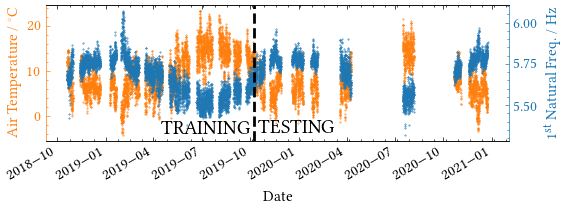

In [800]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize, ncols=1, nrows=1)

freq_vals = df.freq.dropna()

ax2 = ax.twinx()

all_df.air_temperature.plot(ax=ax, ls='', c='C1', marker='.', markersize=0.75).set_rasterized(True)

all_df.freq.plot(ax=ax2, ls='', c='C0', marker='.', markersize=0.75).set_rasterized(True)

ax2.axvline(split_ind, ls='--', c='k', lw='2.0')
ax2.annotate('TRAINING',
             xy=(split_ind-pd.Timedelta('200H'), 5.30),
             ha='right',
             va='bottom',
             fontsize=14.0,
             fontweight='bold')
ax2.annotate('TESTING',
             xy=(split_ind+pd.Timedelta('200H'), 5.30),
             ha='left',
             va='bottom',
             fontsize=14.0,
             fontweight='bold')

ax.set_xlabel('Date')
    
ax.set_ylabel(r'Air Temperature / \unit{\celsius}', c='C1')
ax.tick_params(axis='y', which='both', colors='C1')
ax.spines['left'].set_color('C1')
ax.spines['right'].set_visible(False)

ax2.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}', c='C0')
ax2.tick_params(axis='y', which='both', colors='C0')
ax2.spines['right'].set_color('C0')
ax2.spines['left'].set_visible(False)
    

fig.tight_layout()
ajf_plts.save_fig(fig, 'figTrainTestSplit.pdf')

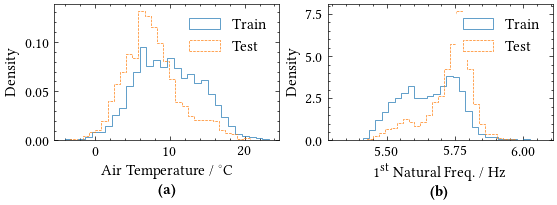

In [801]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2, nrows=1)

axes = axes.ravel()

ax_props = dict(kind='hist', bins=30, density=True, histtype='step', label='Train')

train_df.air_temperature.plot(ax=axes[0], **ax_props)
train_df.freq.plot(ax=axes[1], **ax_props)

ax_props['label'] = 'Test'

test_df.air_temperature.plot(ax=axes[0], **ax_props)
test_df.freq.plot(ax=axes[1], **ax_props)

axes[0].set_xlabel(r'Air Temperature / \unit{\celsius}')
axes[1].set_xlabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
for ax in axes:
    ax.set_ylabel('Density')
    ax.legend(edgecolor='None')
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

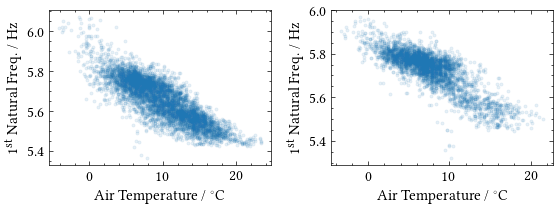

In [802]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=2, nrows=1)

axes = axes.ravel()

ax_props = dict(kind='scatter', marker='.', alpha=0.1)

train_df.plot(ax=axes[0], x='air_temperature', y='freq', **ax_props)

test_df.plot(ax=axes[1], x='air_temperature', y='freq', **ax_props)

for ax in axes:
    ax.set_xlabel(r'Air Temperature / \unit{\celsius}')
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')

fig.tight_layout()

## seasonal trend loess decomposition

In [803]:
import statsmodels.api as sm

In [987]:
rolling_parameters = dict(window=24*28+1, min_periods=24*3, center=True)

trend_train_df = train_df.rolling(**rolling_parameters).mean().dropna()
trend_test_df = test_df.rolling(**rolling_parameters).mean().dropna()

daily_train_df = (train_df - trend_train_df).dropna()
daily_test_df = (test_df - trend_test_df).dropna()

/tmp/ipykernel_8107/3031064289.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(figsize = figsize, nrows=3, ncols=1)


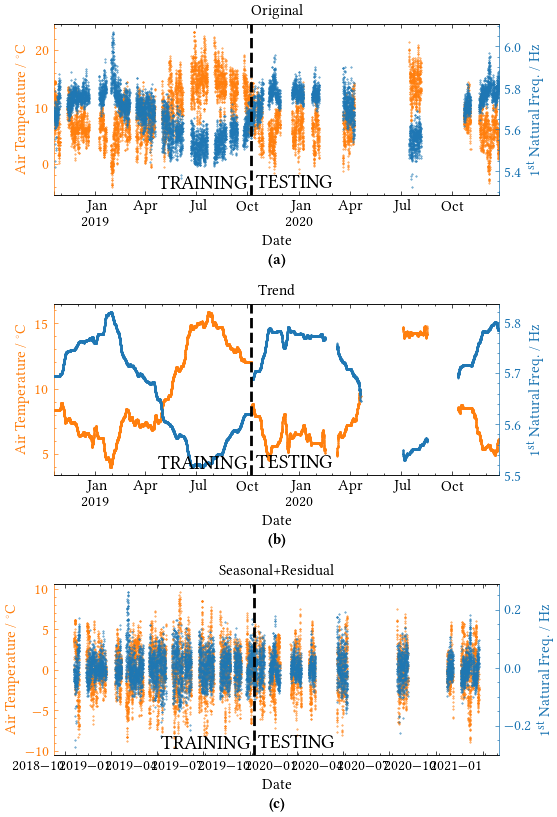

In [988]:
figsize = (ajf_plts.text_width_inches, ajf_plts.text_height_inches)
fig, axes = plt.subplots(figsize = figsize, nrows=3, ncols=1)

axes2 = [ax.twinx() for ax in axes]

# plot original
train_df.air_temperature.plot(ax=axes[0], ls='', c='C1', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)
train_df.freq.plot(ax=axes2[0], ls='', c='C0', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)
test_df.air_temperature.plot(ax=axes[0], ls='', c='C1', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)
test_df.freq.plot(ax=axes2[0], ls='', c='C0', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)

# plot trend
trend_train_df.air_temperature.plot(ax=axes[1], ls='', c='C1', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)
trend_train_df.freq.plot(ax=axes2[1], ls='', c='C0', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)
trend_test_df.air_temperature.plot(ax=axes[1], ls='', c='C1', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)
trend_test_df.freq.plot(ax=axes2[1], ls='', c='C0', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)

# plot seasonal
daily_train_df.air_temperature.plot(ax=axes[2], ls='', c='C1', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)
daily_train_df.freq.plot(ax=axes2[2], ls='', c='C0', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)
daily_test_df.air_temperature.plot(ax=axes[2], ls='', c='C1', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)
daily_test_df.freq.plot(ax=axes2[2], ls='', c='C0', marker='.', markersize=0.75, rasterized=True, rot=0)#.set_rasterized(True)

# titles
axes[0].set_title('Original')
axes[1].set_title('Trend')
axes[2].set_title('Seasonal+Residual')

# x labels
for ax in axes:
    ax.set_xlabel('Date')
    
for ax in axes2:
    ax.axvline(split_ind, ls='--', c='k', lw='2.0')
    ax.annotate('TRAINING',
                xy=(split_ind-pd.Timedelta('200H'),
                    ax.transData.inverted().transform((0.0, ax.transAxes.transform((0.0, 0.01))[1]))[1]),
                ha='right',
                va='bottom',
                fontsize=14.0,
                fontweight='bold')
    ax.annotate('TESTING',
                xy=(split_ind+pd.Timedelta('200H'),
                    ax.transData.inverted().transform((0.0, ax.transAxes.transform((0.0, 0.01))[1]))[1]),
                ha='left',
                va='bottom',
                fontsize=14.0,
                fontweight='bold',
                zorder=10)
    ax.set_zorder(100)

# left y labels
for ax, ax2 in zip(axes, axes2):
    ax.set_ylabel(r'Air Temperature / \unit{\celsius}', c='C1')
    ax.tick_params(axis='y', which='both', colors='C1')
    ax.spines['left'].set_color('C1')
    ax.spines['right'].set_visible(False)
    
    ax2.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}', c='C0')
    ax2.tick_params(axis='y', which='both', colors='C0')
    ax2.spines['right'].set_color('C0')
    ax2.spines['left'].set_visible(False)


ajf_plts.caption_axes(axes)
fig.tight_layout()
ajf_plts.save_fig(fig, 'figSTLtrain.pdf')

## fitting linear model to trend component

In [989]:
X = sm.add_constant(trend_train_df.dropna().air_temperature)
Y = trend_train_df.dropna().freq

res = sm.OLS(endog=Y, exog=X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   freq   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                 8.090e+04
Date:                Fri, 19 Aug 2022   Prob (F-statistic):               0.00
Time:                        23:09:57   Log-Likelihood:                 18029.
No. Observations:                8491   AIC:                        -3.605e+04
Df Residuals:                    8489   BIC:                        -3.604e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               5.9156      0.001   6176.342      0.000       5.914       5.917
air_temperature    -0.0265    9.3e-05   -284.433      0.000      -0.027      -0.026
==============================================================================
Omnibus:                     1178.917   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1752.319
Skew:                          -1.112   Prob(JB):                         0.00
Kurtosis:                       3.053   Cond. No.                         31.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [990]:
trend_train_preds = res.predict()
trend_test_preds = res.predict(exog=sm.add_constant(trend_test_df.dropna().air_temperature))

trend_train_res = trend_train_df.dropna().freq - trend_train_preds
trend_test_res = trend_test_df.dropna().freq - trend_test_preds

In [991]:
from sklearn.metrics import mean_squared_error
print("Train RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(trend_train_df.dropna().freq, trend_train_preds))))
print("Test RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(trend_test_df.dropna().freq, trend_test_preds))))

Train RMSE: 0.029 Hz
Test RMSE: 0.021 Hz


In [992]:
sm.stats.durbin_watson(res.resid)

3.1888735945361845e-05

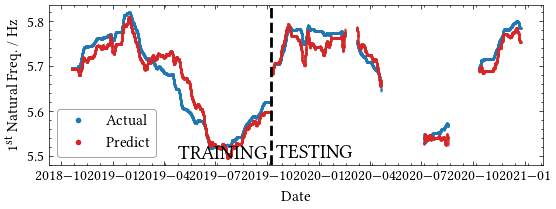

In [993]:
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

actual_paras = dict(ls='', marker='.', c='C0', markersize=0.75, rasterized=True)
predict_paras = dict(ls='', marker='.', c='C3', markersize=0.75, rasterized=True)

ax.plot(trend_train_df.freq, label='Actual', **actual_paras)
ax.plot(trend_test_df.freq, label='_Actual', **actual_paras)

ax.plot(trend_train_df.dropna().index, trend_train_preds, **predict_paras, label='Predict')
ax.plot(trend_test_df.dropna().index, trend_test_preds, **predict_paras, label='_Predict')

ax.axvline(split_ind, ls='--', c='k', lw='2.0')
ax.annotate('TRAINING',
            xy=(split_ind-pd.Timedelta('200H'),
                ax.transData.inverted().transform((0.0, ax.transAxes.transform((0.0, 0.01))[1]))[1]),
            ha='right',
            va='bottom',
            fontsize=14.0,
            fontweight='bold')
ax.annotate('TESTING',
            xy=(split_ind+pd.Timedelta('200H'),
                ax.transData.inverted().transform((0.0, ax.transAxes.transform((0.0, 0.01))[1]))[1]),
            ha='left',
            va='bottom',
            fontsize=14.0,
            fontweight='bold',
            zorder=10)

ax.set_xlabel('Date')
ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
legend = ax.legend()

for lh in legend.legendHandles:
    lh.set_markersize(6)
    
fig.tight_layout()
ajf_plts.save_fig(fig, 'figTrendOLSfit.pdf')

# fit AR model to Air temperature

In [994]:
# check for stationarity
alpha = 0.05
x = daily_train_df.air_temperature.values
x = x.reshape(-1,1)
y = daily_train_df.freq.values

In [995]:
adf_res = sm.tsa.stattools.adfuller(x)
kpss_res = sm.tsa.stattools.kpss(x)
print(f"ADF says {'non-stationary' if adf_res[1] > alpha else 'stationary'}")
print(f"KPSS says {'non-stationary' if kpss_res[1] < alpha else 'stationary'}")

ADF says stationary
KPSS says stationary


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


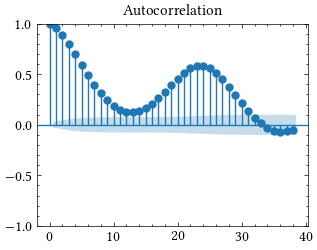

In [996]:
_ = sm.tsa.graphics.plot_acf(x)

/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


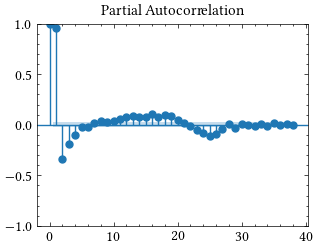

In [997]:
_ = sm.tsa.graphics.plot_pacf(x)

In [998]:
model = sm.tsa.ARIMA(endog=x,
                     order=(4,0,0),
                     trend='n').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5663
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -6410.948
Date:                Fri, 19 Aug 2022   AIC                          12831.896
Time:                        23:10:09   BIC                          12865.104
Sample:                             0   HQIC                         12843.462
                               - 5663                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1938      0.009    132.040      0.000       1.176       1.211
ar.L2         -0.1025      0.014     -7.308      0.000      -0.130      -0.075
ar.L3         -0.0616      0.016     -3.744      0.000      -0.094      -0.029
ar.L4         -0.1055      0.011     -9.255      0.000      -0.128      -0.083
sigma2         0.5631      0.005    119.024      0.000       0.554       0.572
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):             21856.51
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.47   Skew:                             0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

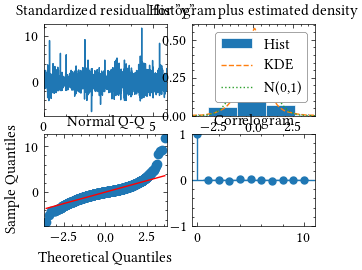

In [999]:
_ = model.plot_diagnostics()

## pre-whiten the endog input

In [1000]:
filt_exog = sm.tsa.filters.convolution_filter(x, np.r_[1, -model.params[:-1]], nsides=1)
filt_endog = sm.tsa.filters.convolution_filter(y, np.r_[1, -model.params[:-1]], nsides=1)

filt_exog = filt_exog[~np.isnan(filt_exog)]
filt_endog = filt_endog[~np.isnan(filt_endog)]

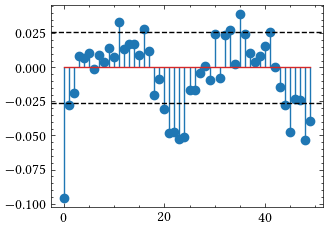

In [1001]:
ccf = sm.tsa.ccf(filt_exog, filt_endog)

fig, ax = plt.subplots()
plt.stem(ccf[:50])
plt.axhline(-1.96/np.sqrt(len(filt_exog)), color='k', ls='--')
plt.axhline(1.96/np.sqrt(len(filt_exog)), color='k', ls='--')

# fit arima model

In [974]:
order = sm.tsa.ardl_select_order(endog=y,
                          exog=x.reshape(-1,1),
                          maxlag=4,
                          maxorder=1,
                          causal=False,
                          trend='n',
                         )

In [975]:
order.ar_lags, order.dl_lags

([1, 2], {0: [0, 1]})

In [976]:
model = sm.tsa.ARDL(endog=y,
                    exog=x.reshape(-1,1),
                    lags=order.ar_lags,
                    order=order.dl_lags,
                    trend='n').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARDL Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5663
Model:                     ARDL(2, 1)   Log Likelihood               12423.950
Method:               Conditional MLE   S.D. of innovations              0.027
Date:                Fri, 19 Aug 2022   AIC                         -24837.899
Time:                        23:08:33   BIC                         -24804.692
Sample:                             2   HQIC                        -24826.334
                                 5663                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.6506      0.013     49.080      0.000       0.625       0.677
y.L2           0.0737      0.013      5.768      0.000       0.049       0.099
x0.L0         -0.0064      0.000    -14.177      0.000      -0.007      -0.006
x0.L1          0.0024      0.000      5.080      0.000       0.001       0.003
==============================================================================
"""

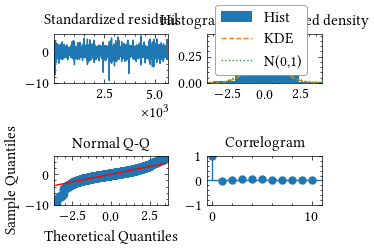

In [977]:
_=model.plot_diagnostics()
plt.tight_layout()

In [978]:
x_test = daily_test_df.air_temperature.values.reshape(-1,1)
y_test = daily_test_df.freq.values 

In [979]:
daily_train_preds = np.nan_to_num(model.predict(exog_oos=x))
daily_test_preds = np.nan_to_num(model.predict(start=len(x), end=len(x)+len(x_test)-1, exog_oos=x_test))

daily_train_res = y - train_preds
daily_test_res = y_test - test_preds

In [980]:
from sklearn.metrics import mean_squared_error
print("Train RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(y, train_preds))))
print("Test RMSE: %.3f Hz" % (np.sqrt(mean_squared_error(y_test, test_preds))))

Train RMSE: 0.027 Hz
Test RMSE: 0.037 Hz


In [981]:
sm.stats.durbin_watson(train_res)

2.011626950045352

In [982]:
sm.stats.durbin_watson(test_res)

0.5608310413143

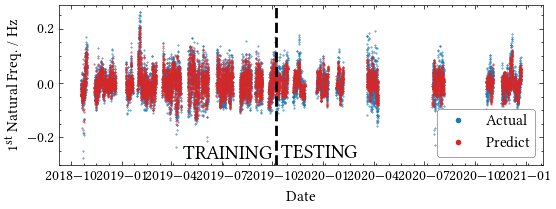

In [983]:
figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

actual_paras = dict(ls='', marker='.', c='C0', markersize=0.75, rasterized=True)
predict_paras = dict(ls='', marker='.', c='C3', markersize=0.75, rasterized=True)

ax.plot(daily_train_df.freq, label='Actual', **actual_paras)
ax.plot(daily_test_df.freq, label='_Actual', **actual_paras)

ax.plot(daily_train_df.index, daily_train_preds, **predict_paras, label='Predict')
ax.plot(daily_test_df.index, daily_test_preds, **predict_paras, label='_Predict')

ax.axvline(split_ind, ls='--', c='k', lw='2.0')
ax.annotate('TRAINING',
            xy=(split_ind-pd.Timedelta('200H'),
                ax.transData.inverted().transform((0.0, ax.transAxes.transform((0.0, 0.01))[1]))[1]),
            ha='right',
            va='bottom',
            fontsize=14.0,
            fontweight='bold')
ax.annotate('TESTING',
            xy=(split_ind+pd.Timedelta('200H'),
                ax.transData.inverted().transform((0.0, ax.transAxes.transform((0.0, 0.01))[1]))[1]),
            ha='left',
            va='bottom',
            fontsize=14.0,
            fontweight='bold',
            zorder=10)

ax.set_xlabel('Date')
ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
legend = ax.legend()

for lh in legend.legendHandles:
    lh.set_markersize(6)
    
fig.tight_layout()
ajf_plts.save_fig(fig, 'figDailyARDLfit.pdf')

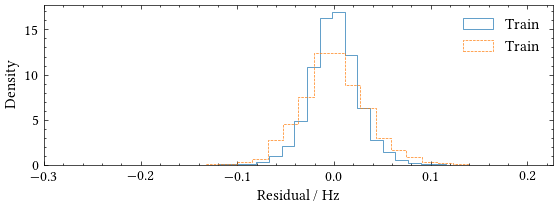

In [852]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

ax_props = dict(bins=30, density=True, histtype='step', label='Train')

ax.hist(daily_train_res, **ax_props)
ax.hist(daily_test_res, **ax_props)
#train_res.plot(ax=ax, **ax_props)
#test_res.plot(ax=ax, **ax_props)

ax.set_xlabel(r'Air Temperature / \unit{\celsius}')
ax.set_xlabel(r'Residual / \unit{\hertz}')
ax.set_ylabel('Density')
ax.legend(edgecolor='None')
    
fig.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


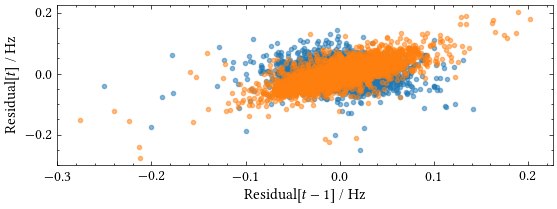

In [857]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig, ax = plt.subplots(figsize=figsize)

ax.plot(daily_train_res[:-1], daily_train_res[1:], ls='', marker='.', alpha=0.5)
ax.plot(daily_test_res[:-1], daily_test_res[1:], ls='', marker='.', alpha=0.5)
#train_res.plot(ax=ax, **ax_props)
#test_res.plot(ax=ax, **ax_props)

ax.set_xlabel(r'Air Temperature / \unit{\celsius}')
ax.set_xlabel(r'Residual$\left[{t-1}\right]$ / \unit{\hertz}')
ax.set_ylabel(r'Residual$\left[{t}\right]$ / \unit{\hertz}')
ax.legend(edgecolor='None')
    
fig.tight_layout()

NameError: name 'yc' is not defined

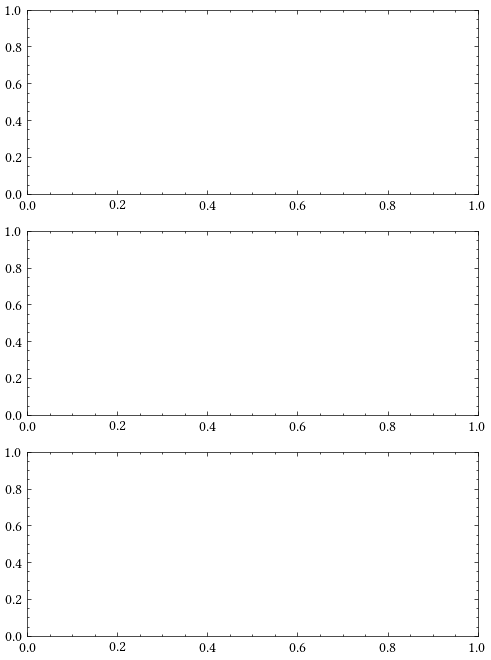

In [833]:
%matplotlib widget
figsize=(ajf_plts.text_width_inches, 3.5*ajf_plts.fig_height_inches)
fig, axes = plt.subplots(figsize=figsize, ncols=1, nrows=3)

axes = axes.ravel()

props = dict(ls='', marker='.')

for ax in axes:
    ax.plot(np.concatenate([train_df.index, test_df.index]), np.concatenate([yc, yc_test])+np.mean(y),  **props, label='Actual')
    ax.plot(np.concatenate([train_df.index, test_df.index]), np.concatenate([train_preds, test_preds])+np.mean(y),  **props, label='Predicted')
    vl = ax.axvline(all_df.index.values[split_ind], ls='--', c='k', lw='2.0')
    vl_x_ax = ax.transAxes.inverted().transform(axes[0].transData.transform(vl.get_xydata()[0]))[0]
    ax.annotate('TRAINING',
            xy=(0.95*vl_x_ax, 0.95),
            xycoords='axes fraction',
            ha='right',
            va='top',
            fontsize=14.0,
            fontweight='bold')
    ax.annotate('TESTING',
                 xy=(1.05*vl_x_ax, 0.95),
                 xycoords='axes fraction',
                 ha='left',
                 va='top',
                 fontsize=14.0,
                 fontweight='bold')

train_start = pd.to_datetime('2019-5-1')
train_end = pd.to_datetime('2019-5-8')

axes[0].axvspan(train_start, train_end, fc='C3')
axes[1].set_xlim([train_start, train_end])

test_start = pd.to_datetime('2020-12-12')
test_end = pd.to_datetime('2020-12-19')

axes[0].axvspan(test_start, test_end, fc='C3')
axes[2].set_xlim([test_start, test_end])

for ax in axes:
    ax.set_xlabel('Date')
    ax.set_ylabel(r'1\textsuperscript{st} Natural Freq. / \unit{\hertz}')
    ax.legend()
    
ajf_plts.caption_axes(axes)
fig.tight_layout()

0.6448593243384588